## Working With Numpy

In this notebook, we'll go over some of the uses of numpy, which is one of the standard python libraries for numerical methods. If you're familiar with MATLAB, many of the functions that you're used to can be translated directly over to numpy, and we'll provide a handout including some common functions.

If you're using anaconda, numpy, scipy, and matplotlib should all be installed already. If you're using pip, you may need to install these using:

In [6]:
"pip install numpy matplotlib"

'pip install numpy matplotlib'

If you copy the above text into your terminal prompt without the quotation marks (""), Python should install the packages automatically. Numpy relies on scipy, and so will install it automatically alongside itself. To use numpy, it's typical to use the syntax:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi

First off, we'll import numpy and pyplot. Like numpy, Pyplot is a commonly used library for plotting figures. 

As an initial exercise, let's use numpy to calculate the trajectory of a ball that is thrown with some initial conditions. Let's assume a ball of mass 0.5kg, that is launched from an initial altitude on an angle $\theta$ with a velocity $v$. At this stage, we'll assume a frictionless environment:

In [17]:
mass = 0.5             # mass of the ball in kg
theta = 45*pi/180      # angle at which the ball is launched
v = 20.                # launch speed of the ball at time t0
t = 0.                 # initial time
dt = 1e-3              # integrator time step
g = -9.81              # gravitational acceleration
x = 0.                 # initial x position
y = 0.                 # initial y position

Having included all of our initial conditions, we'll use Euler integration to step our simulation forward. This is the simplest type of integrator, taking the form:

\begin{equation*}
v_{t} = v_{t-1}+a_{t}\Delta t
\end{equation*}

\begin{equation*}
x_{t} = x_{t-1}+v_{t}\Delta t
\end{equation*}

Our algorithm is pretty straightforward: at each time step, we calculate the forces acting on the ball (in this case, only gravity), and then use this to find the accelerations in each direction. From there, we can step velocity and position forward.

In [18]:
G = np.array([0., g])                      # create numpy array for the gravity vector
X = np.array([x, y])                       # create numpy array for the position vector
V = np.array([v*cos(theta), v*sin(theta)]) # create numpy array for the velocity vector

position = []                              # list to hold position data
velocity = []                              # list to hold velocity data
time = []                                  # list to hold time data
running = True
while running:
    position.append(X.copy())              # append position to list
    velocity.append(V.copy())              # append velocity to list
    time.append(t)                         # append time to list
    A = 0/mass+G                           # no drag, so acceleration is only due to gravity here
    V = V+A*dt                             # update velocity
    X = X+V*dt                             # update position
    t += dt                                # update time
    if X[1] <= 0:
        running = False                    # if ball has dropped below ground level, terminate simulation

Now that we have the data, we'll use matplotlib to plot the trajectory:

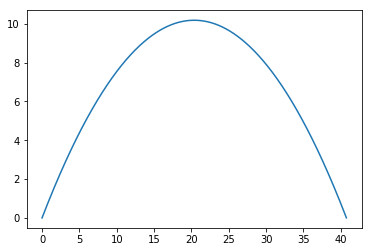

In [19]:
position = np.vstack(position)
ax = plt.axes()
ax.plot(position[:,0], position[:,1])
plt.show()

### Another Example -- Optimization

Let's play around with some optimization. Numpy and SciPy have several inbuilt solvers, and functions for you to test your own solvers on. The syntax is largely similar to MATLAB's, and the library of solvers available for you to use is also roughly similar.

For this exercise, we'll first use optimization for a simple regression task by generating noisy data in numpy, and then using scipy's inbuilt fmin solvers to fit the dataset. To begin with, we'll generate the data:

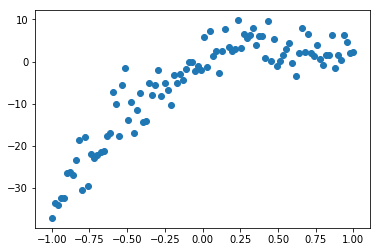

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

x = np.linspace(-1, 1, 100)                         # x range
A = np.random.randn()*10                            # generate random slope
B = np.random.randn()*10                            # generate random intercept
C = np.random.randn()*10
y = (A*x**2+B*x+C)+4*np.random.randn(100)        # add noise to the function
ax = plt.axes()                                  # create a figure
ax.scatter(x,y)
plt.show()

Next, we'll put together a cost function that will tell us how good our regression fit is:

In [24]:
def cost(theta, x, targ):
    pred = theta.T.dot(x)
    loss = -0.5*(pred-targ)**2
    loss = -np.mean(loss, axis=-1)
    return loss

Finally, we'll use a set of input features and scipy's minimize function to fit the data. We'll use our human intuition to guess that the data is drawn from a quadratic function, meaning we want to find a function of the form $Ax^2 + Bx + C$. Let's rewrite this as $[\theta_0; \theta_1; \theta_2]^T [x^2; x; 1]$ instead -- then our function is simply $\Theta^T X$, and we can use numpy's inbuilt dot operator to handle the linear algebra for us.

The shape of x_vec is:  (3, 100)
The shape of theta_0 is:  (3, 1)
A value:  -16.021647352869337
B value:  16.38674903506361
C value:  0.05890221249021144
Found values:  [-17.47717379  16.93768005   0.35816618]


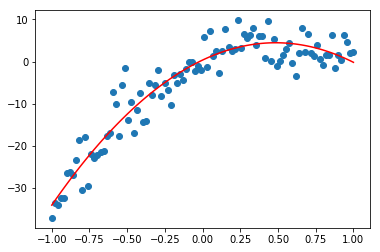

In [31]:
x_vec = np.vstack([x**2, x, np.ones(x.shape)])
theta_0 = np.random.randn(x_vec.shape[0], 1)
print("The shape of x_vec is: ", x_vec.shape)
print("The shape of theta_0 is: ", theta_0.shape)
theta = minimize(cost, theta_0, args=(x_vec, y), method="CG")

print("A value: ", A)
print("B value: ", B)
print("C value: ", C)
print("Found values: ", theta.x)

y_pred = np.array(theta.x).dot(x_vec)
ax = plt.axes()                                  # create a figure
ax.scatter(x,y)
ax.plot(x, y_pred, "r")
plt.show()

Next we'll write our optimization routine. This will be a function that takes in a set of Xs, and a known set of outputs Y. Our goal will be to learn a set of parameters $\theta$ such that $y=\sum_{i=0}^{N}\theta_{i}x^{i}$. The way evolutionary strategies typically work is to place distributions $\mathcal{N}(\mu, \sigma)$ over each parameter $\theta$, and then to draw many samples from these distributions. A fitness (or score, or cost) function is then used to evaluate the parameters, which are then ranked. We take the best parameters, and then combine them to form a new set of distributions using the $\mu$ and $\sigma$ of the best scoring parameters.

In [26]:
"""
Regression example using the cross entropy method. The purpose of this
script is to give an idea of how nested functions can be used.

-- Sean Morrison, 2018
"""

def optimize_f(x, y_targ, mean=0., std=100., samples=10000, elite_frac=0.2, deg=1, max_iters=100, thresh=1e-2):
    # outer optimization function
    
    def cost(pred, targ):
        # mean squared-error cost function
        loss = -0.5*(pred-targ)**2
        return np.mean(loss, axis=-1)
    
    x = np.vstack([x**i for i in reversed(range(deg+1))])
    best_n = int(elite_frac*samples)
    iteration = 1
    prev_cost = None
    delta = None
    mu, dev = np.ones((deg+1,))*mean, np.ones((deg+1,))*std
    running = True
    while running:
        theta = np.random.normal(mu, dev, (samples, deg+1))
        y_pred = theta.dot(x)
        loss = cost(y_pred, np.tile(y_targ, (samples, 1)))
        idxs = np.argsort(loss)[::-1]
        best = idxs[0:best_n]
        absolute_cost = np.abs(loss[idxs[best]].mean())
        print("--- Iteration: {}, Loss: {:.5f} ---".format(iteration, loss[idxs[best]].mean()))
        if absolute_cost <= thresh:
            print("Termination threshold reached. Current cost is {:.5f}".format(absolute_cost))
            running = False
        elif iteration >= max_iters:
            print("Maximum iterations reached. Current cost is {:.5f}".format(absolute_cost))
            running = False
        elif prev_cost is not None:
            delta = abs(absolute_cost-prev_cost)
            if delta <= 1e-5:
                print("Algorithm converged after {} iterations at cost {:.5f}".format(iteration, absolute_cost))
                running = False
        best_theta = theta[best, :]
        mu, dev = best_theta.mean(axis=0), best_theta.std(axis=0)
        prev_cost = absolute_cost
        iteration += 1
    return mu

Now that we've defined our optimization function, we'll test it out with some random data:

--- Iteration: 1, Loss: -7965.65852 ---
--- Iteration: 2, Loss: -1644.74920 ---
--- Iteration: 3, Loss: -398.18021 ---
--- Iteration: 4, Loss: -100.97243 ---
--- Iteration: 5, Loss: -29.05796 ---
--- Iteration: 6, Loss: -11.94152 ---
--- Iteration: 7, Loss: -7.80128 ---
--- Iteration: 8, Loss: -6.70840 ---
--- Iteration: 9, Loss: -6.47024 ---
--- Iteration: 10, Loss: -6.41082 ---
--- Iteration: 11, Loss: -6.39592 ---
--- Iteration: 12, Loss: -6.39244 ---
--- Iteration: 13, Loss: -6.39166 ---
--- Iteration: 14, Loss: -6.39148 ---
--- Iteration: 15, Loss: -6.39143 ---
--- Iteration: 16, Loss: -6.39142 ---
--- Iteration: 17, Loss: -6.39142 ---
Algorithm converged after 17 iterations at cost 6.39142
A: -16.021647352869337
B: 16.38674903506361
C: 0.05890221249021144
Optimized Theta: [-17.47723069  16.93764827   0.35819886]


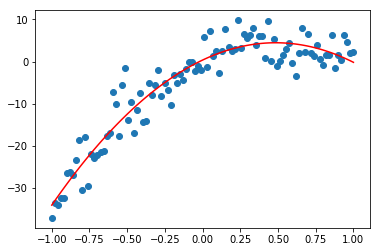

In [29]:
theta = optimize_f(x, y, deg=2)           # call optimization fn
print("A: {}".format(A))
print("B: {}".format(B))
print("C: {}".format(C))
print("Optimized Theta: {}".format(theta))
x_vec = np.vstack([x**i for i in reversed(range(3))])
y_pred = theta.reshape(1,-1).dot(x_vec)
ax = plt.axes()
ax.scatter(x, y)
ax.plot(x, y_pred[0,:], "-r")                 # plot the line given by THETA
plt.show()      

From the output, we can see that our evolutionary strategy has not only regressed the data, it's found almost the exact same coefficients that the conjugate gradient method did above. That's kind of neat. Aaaand this is also our first introduction to machine learning and AI, which will be covered in a later workshop.